In [1]:
import os
import numpy as np
import pickle
import shap
import lime
import lime.lime_tabular
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [5]:
#! pip install shap
!pip install lime

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=52e8c4480fa0041b85d44a66af2997172535de5da213bd4042d24ccdf301476a
  Stored in directory: /jet/home/wli22/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [20]:
# Test story: pick 2 test story
import os
from sklearn.model_selection import train_test_split

embedding_dir = "../results/embeddings/bert_XY"
story_files = sorted([f[:-6] for f in os.listdir(embedding_dir) if f.endswith("_X.npy")])
train_stories, test_stories = train_test_split(story_files, test_size=0.2, random_state=42)

print("Test stories:")
for s in test_stories:
    print(s)

Test stories:
thepostmanalwayscalls
marryamanwholoveshismother
reachingoutbetweenthebars
seedpotatoesofleningrad
jugglingandjesus
howtodraw
comingofageondeathrow
itsabox
birthofanation
adollshouse
catfishingstrangerstofindmyself
fromboyhoodtofatherhood
whenmothersbullyback
goldiethegoldfish
tetris
againstthewind
treasureisland
thatthingonmyarm
breakingupintheageofgoogle
gangstersandcookies
swimmingwithastronauts


# Story 1: tetris


### 1: top 5 voxels

In [10]:
fig_dir = "figure"
os.makedirs(fig_dir, exist_ok=True)

# ===== Load data =====
story_id = "tetris"
X = np.load(f"../results/embeddings/bert_XY/{story_id}_X.npy")
Y = np.load(f"../results/embeddings/bert_XY/{story_id}_Y.npy")
wt = np.load("ridge_weights.npy")
corrs = np.load("ridge_corrs.npy")

# ===== Select best voxel =====
top_5_voxel = np.argsort(corrs)[-5:]                         
top_5_voxel = top_5_voxel[np.argsort(corrs[top_5_voxel])[::-1]]
print(top_5_voxel)

[16841 19609  6465 13744 16789]


### 2: Map back to words

In [18]:
import os
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
import matplotlib as mpl
from collections import defaultdict
import numpy as np

def run_shap_lime_for_voxels(story_id, X, Y, wt, corrs, raw_texts, voxel_indices, fig_dir="figure"):

    os.makedirs(fig_dir, exist_ok=True)

    tokens = raw_texts[story_id].data
    tr_times = raw_texts[story_id].tr_times
    data_times = raw_texts[story_id].data_times
    token_times = data_times
    TR = np.mean(np.diff(tr_times))
    n_delays = 5
    n_feat_per_TR = X.shape[1] // n_delays

    def get_words_for_tr(tr, window=1.5):
        start_time = tr - window / 2
        end_time = tr + window / 2
        return [w for w, t in zip(tokens, data_times) if start_time <= t <= end_time]

    results = {}

    for top_voxel in voxel_indices:
        print(f"\n===== Processing Voxel {top_voxel} =====")

        # pred
        def predict_fn(X_input):
            return np.dot(X_input, wt[:, top_voxel])

        # SHAP
        mpl.rcParams['xtick.labelsize'] = 10
        mpl.rcParams['ytick.labelsize'] = 10
        mpl.rcParams['font.size'] = 10
        mpl.rcParams['lines.markersize'] = 10

        explainer_shap = shap.KernelExplainer(predict_fn, X[:100])
        shap_values = explainer_shap.shap_values(X[:20])

        plt.figure()
        shap.summary_plot(
            shap_values,
            X[:20],
            max_display=10,
            show=False,
            plot_size=(8, 5)
        )
        plt.title(f"SHAP Explanation for Voxel {top_voxel} (Story: {story_id})")
        plt.tight_layout()
        plt.savefig(os.path.join(fig_dir, f"{story_id}_shap_summary_voxel{top_voxel}.png"))
        plt.close()

        # LIME 
        lime_explainer = lime.lime_tabular.LimeTabularExplainer(
            training_data=X,
            mode="regression",
            feature_names=[f"dim_{i}" for i in range(X.shape[1])],
            discretize_continuous=True
        )

        lime_exp = lime_explainer.explain_instance(X[0], predict_fn, num_features=10)
        fig = lime_exp.as_pyplot_figure()
        plt.title(f"LIME Explanation for Voxel {top_voxel} (Story: {story_id})")
        plt.tight_layout()
        plt.savefig(os.path.join(fig_dir, f"{story_id}_lime_voxel{top_voxel}.png"))
        plt.close()

        # SHAP to Token 
        shap_token_results = []
        ## Select top 10
        top_shap_idx = np.argsort(np.abs(np.array(shap_values)).mean(0))[::-1][:10]
        for idx in top_shap_idx:
            tr_idx = idx % X.shape[0]
            delay = idx // n_feat_per_TR
            words = get_words_for_tr(tr_times[tr_idx])
            shap_token_results.extend(words)

        # LIME to Token 
        lime_token_results = []
        ## Select top 10
        lime_top_idx = list(dict(lime_exp.as_map()[1]).keys())[:10]
        for idx in lime_top_idx:
            tr_idx = idx % len(tr_times)
            delay = idx // n_feat_per_TR
            lag_time = tr_times[tr_idx] - delay * TR
            window = TR / 2
            matched_tokens = [w for w, t in zip(tokens, token_times) if (lag_time - window) <= t <= (lag_time + window)]
            lime_token_results.extend(matched_tokens)

        # Store Into results
        results[top_voxel] = {
            "shap_tokens": shap_token_results,
            "lime_tokens": lime_token_results
        }

    return results


In [19]:
raw_texts = pickle.load(open("../../../shared/data/raw_text.pkl", "rb"))

results = run_shap_lime_for_voxels(
    story_id=story_id,
    X=X,
    Y=Y,
    wt=wt,
    corrs=corrs,
    raw_texts=raw_texts,
    voxel_indices=top_5_voxel
)



===== Processing Voxel 16841 =====


  0%|          | 0/20 [00:00<?, ?it/s]


===== Processing Voxel 19609 =====


  0%|          | 0/20 [00:00<?, ?it/s]


===== Processing Voxel 6465 =====


  0%|          | 0/20 [00:00<?, ?it/s]


===== Processing Voxel 13744 =====


  0%|          | 0/20 [00:00<?, ?it/s]


===== Processing Voxel 16789 =====


  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
import pickle

with open("tetris_voxel_results.pkl", "wb") as f:
    pickle.dump(results, f)

print(results)

{16841: {'shap_tokens': ['would', 'go', 'on', 'to', 'infect', 'time', 'and', 'space', 'come', 'in', 'seven', 'possible', 'and', 'tomb', 'raider', 'received', 'no', 'royalties', 'until', 'he', 'fell', 'in', 'the', 'darkness', 'genuinely', 'cannot', 'afford', 'to', 'the', 'soviet', 'union', 'tetris', 'remained', 'enduringly', 'and', 'dreams', 'of', 'millions'], 'lime_tokens': ['brief', 'miraculous', 'flicker', 'of', 'during', 'rare', 'jaunts', 'from', 'the', 'house', 'he', 'worked', 'on', 'pajitnov', 'liked', 'the', 'soviet', 'government', 'then', 'formed', 'an', 'tetramino', 'being', 'a', 'shape', 'composed', 'because', 'he', 'was', 'afraid', 'not', 'to', 'the', 'same', 'way', 'no', 'matter', 'how', 'expertly', 'piece', 'and', 'then', 'the', 'thrill', 'and', 'myself', 'from', 'feeling', 'four', 'the', 'computer', 'programmer']}, 19609: {'shap_tokens': ['would', 'go', 'on', 'to', 'infect', 'time', 'and', 'space', 'come', 'in', 'seven', 'possible', 'and', 'tomb', 'raider', 'received', 'no

### 3: Words Analysis

In [23]:
! pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 9.6 MB/s eta 0:00:00


In [5]:
import pickle

with open("tetris_voxel_results.pkl", "rb") as f:
    results = pickle.load(f)

print(results[16841])

{'shap_tokens': ['would', 'go', 'on', 'to', 'infect', 'time', 'and', 'space', 'come', 'in', 'seven', 'possible', 'and', 'tomb', 'raider', 'received', 'no', 'royalties', 'until', 'he', 'fell', 'in', 'the', 'darkness', 'genuinely', 'cannot', 'afford', 'to', 'the', 'soviet', 'union', 'tetris', 'remained', 'enduringly', 'and', 'dreams', 'of', 'millions'], 'lime_tokens': ['brief', 'miraculous', 'flicker', 'of', 'during', 'rare', 'jaunts', 'from', 'the', 'house', 'he', 'worked', 'on', 'pajitnov', 'liked', 'the', 'soviet', 'government', 'then', 'formed', 'an', 'tetramino', 'being', 'a', 'shape', 'composed', 'because', 'he', 'was', 'afraid', 'not', 'to', 'the', 'same', 'way', 'no', 'matter', 'how', 'expertly', 'piece', 'and', 'then', 'the', 'thrill', 'and', 'myself', 'from', 'feeling', 'four', 'the', 'computer', 'programmer']}



Top 20 SHAP tokens:
to: 15
and: 14
in: 8
he: 6
would: 5
go: 5
on: 5
infect: 5
time: 5
space: 5
come: 5
seven: 5
possible: 5
tomb: 5
raider: 5
received: 5
no: 5
royalties: 5
until: 5
the: 5

Top 20 LIME tokens:
the: 17
and: 11
of: 7
from: 7
then: 7
to: 6
brief: 5
miraculous: 5
flicker: 5
he: 5
soviet: 5
a: 5
during: 4
rare: 4
jaunts: 4
house: 4
worked: 4
on: 4
pajitnov: 4
liked: 4


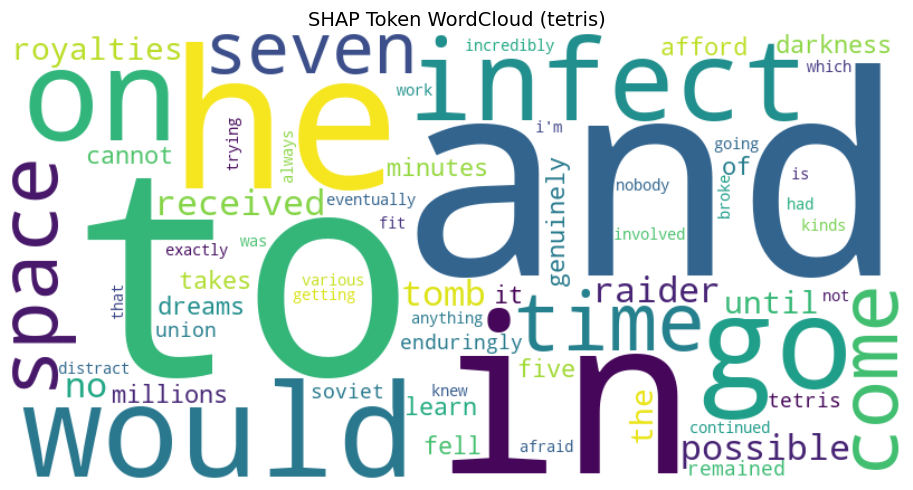

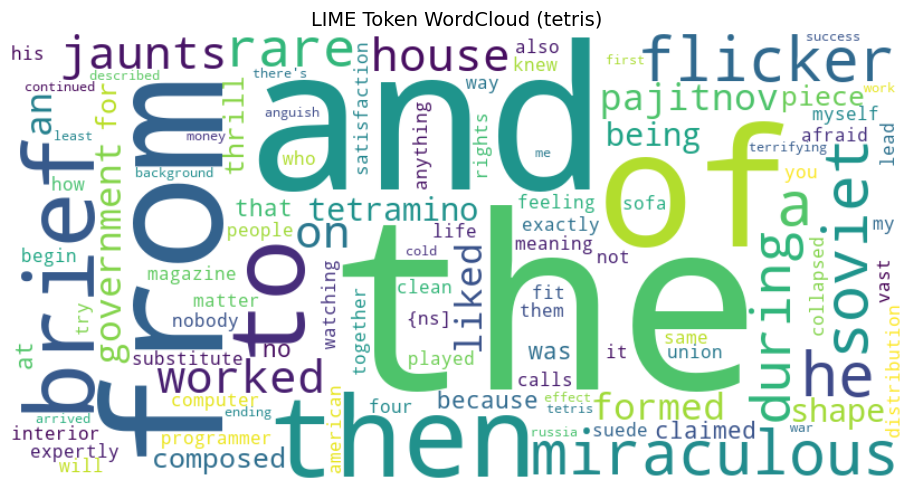

In [6]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os

fig_dir = "figure"
story_id = "tetris"
os.makedirs(fig_dir, exist_ok=True)

all_shap_tokens = []
all_lime_tokens = []

for voxel_id, token_dict in results.items():
    all_shap_tokens.extend(token_dict["shap_tokens"])
    all_lime_tokens.extend(token_dict["lime_tokens"])

shap_counts = Counter(all_shap_tokens)
lime_counts = Counter(all_lime_tokens)

# top 20 
top_k = 20
print(f"\nTop {top_k} SHAP tokens:")
for word, freq in shap_counts.most_common(top_k):
    print(f"{word}: {freq}")

print(f"\nTop {top_k} LIME tokens:")
for word, freq in lime_counts.most_common(top_k):
    print(f"{word}: {freq}")

# SHAP
wordcloud_shap = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(shap_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_shap, interpolation='bilinear')
plt.axis("off")
plt.title(f"SHAP Token WordCloud ({story_id})", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f"{story_id}_shap_wordcloud.png"))
plt.show()

# LIME
wordcloud_lime = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(lime_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_lime, interpolation='bilinear')
plt.axis("off")
plt.title(f"LIME Token WordCloud ({story_id})", fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f"{story_id}_lime_wordcloud.png"))
plt.show()


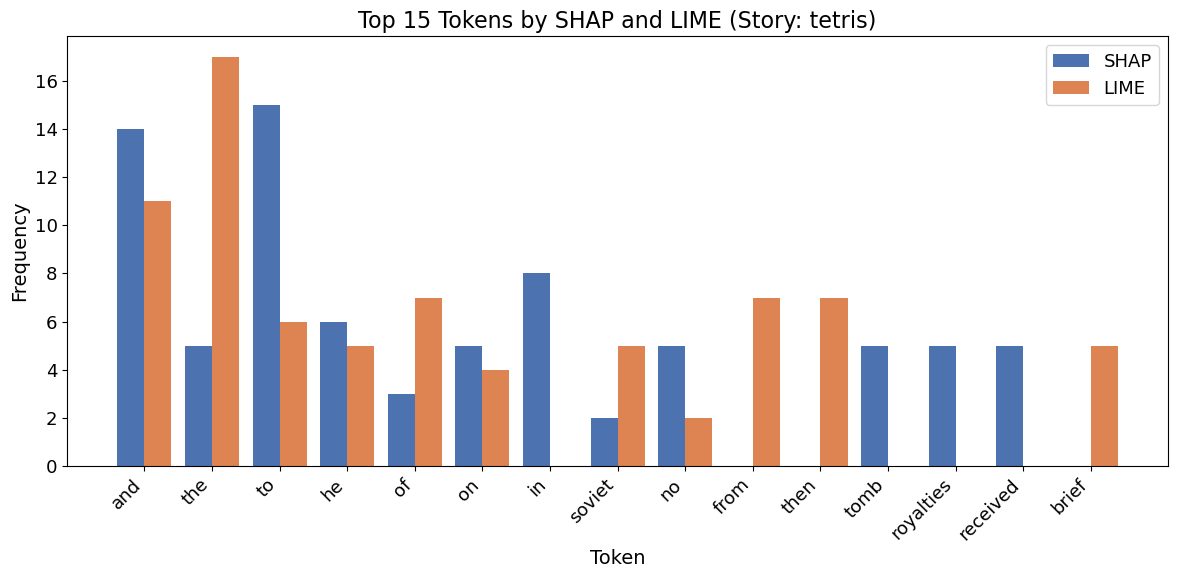

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs(fig_dir, exist_ok=True)

# Frequency DataFrame
all_words = set(shap_counts.keys()) | set(lime_counts.keys())
word_stats = []

for word in all_words:
    word_stats.append({
        "word": word,
        "shap_freq": shap_counts[word],
        "lime_freq": lime_counts[word]
    })

df = pd.DataFrame(word_stats)
df["total_freq"] = df["shap_freq"] + df["lime_freq"]
df_sorted = df.sort_values(by="total_freq", ascending=False)

csv_path = os.path.join(fig_dir, f"{story_id}_shap_lime_token_comparison.csv")
df_sorted.to_csv(csv_path, index=False)

# freq top 15 token
top_k = 15
df_top = df_sorted.head(top_k)

plt.figure(figsize=(12, 6))
bar_width = 0.4
x = range(len(df_top))


shap_color = "#4C72B0"
lime_color = "#DD8452"

plt.rcParams.update({
    "font.size": 14,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "axes.labelsize": 14,
    "axes.titlesize": 16,
    "legend.fontsize": 13
})

plt.bar(x, df_top["shap_freq"], width=bar_width, label="SHAP", color=shap_color)
plt.bar([i + bar_width for i in x], df_top["lime_freq"], width=bar_width, label="LIME", color=lime_color)
plt.xticks([i + bar_width / 2 for i in x], df_top["word"], rotation=45, ha="right")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.title(f"Top {top_k} Tokens by SHAP and LIME (Story: {story_id})")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, f"{story_id}_shap_lime_bar_comparison_styled.png"))
plt.show()


In [11]:
shap_set = set(shap_counts.keys())
lime_set = set(lime_counts.keys())
intersection = shap_set & lime_set
shap_only = shap_set - lime_set
lime_only = lime_set - shap_set

print(f" SHAP–LIME Token Intersection: {len(intersection)} tokens")
print(f" SHAP-only Tokens: {len(shap_only)}")
print(f" LIME-only Tokens: {len(lime_only)}")

print("\n Example Overlap Tokens:", list(intersection)[:5])
print(" SHAP-only Examples:", list(shap_only)[:5])
print(" LIME-only Examples:", list(lime_only)[:5])

 SHAP–LIME Token Intersection: 22 tokens
 SHAP-only Tokens: 42
 LIME-only Tokens: 82

 Example Overlap Tokens: ['work', 'that', 'soviet', 'fit', 'of']
 SHAP-only Examples: ['getting', 'distract', 'incredibly', 'remained', 'millions']
 LIME-only Examples: ['house', 'sofa', 'least', 'watching', 'formed']


In [8]:
# fig_dir = "figure"
# os.makedirs(fig_dir, exist_ok=True)

# # ===== Load data =====
# story_id = "tetris"
# X = np.load(f"../results/embeddings/bert_XY/{story_id}_X.npy")
# Y = np.load(f"../results/embeddings/bert_XY/{story_id}_Y.npy")
# wt = np.load("ridge_weights.npy")
# corrs = np.load("ridge_corrs.npy")

# # ===== Select best voxel =====
# top_5_voxel = np.argsort(corrs)[-5:]                         
# top_5_voxel = top_5_voxel[np.argsort(corrs[top_5_voxel])[::-1]]
# print(top_5_voxel)

# top_voxel = 16841
# ridge_model = Ridge()
# ridge_model.coef_ = wt[:, top_voxel]
# ridge_model.intercept_ = 0.0

# def predict_fn(X_input):
#     return np.dot(X_input, wt[:, top_voxel])

[16841 19609  6465 13744 16789]


In [4]:
# # ===== SHAP explanation =====

# import matplotlib as mpl
# mpl.rcParams['xtick.labelsize'] = 10
# mpl.rcParams['ytick.labelsize'] = 10
# mpl.rcParams['font.size'] = 10
# mpl.rcParams['lines.markersize'] = 6

# explainer_shap = shap.KernelExplainer(predict_fn, X[:100])  # first 100 TR as background
# shap_values = explainer_shap.shap_values(X[:20])  # explain first 20 time steps

# plt.figure()
# shap.summary_plot(
#     shap_values, 
#     X[:20], 
#     max_display=10, 
#     show=False,
#     plot_size=(8, 5) 
# )
# plt.title(f"SHAP Explanation for Voxel {top_voxel} (Story: {story_id})")
# plt.tight_layout()
# plt.savefig(os.path.join(fig_dir, f"{story_id}_shap_summary_voxel{top_voxel}.png"))
# plt.close()



# # ===== LIME explanation =====
# lime_explainer = lime.lime_tabular.LimeTabularExplainer(
#     training_data=X,
#     mode="regression",
#     feature_names=[f"dim_{i}" for i in range(X.shape[1])],
#     discretize_continuous=True
# )

# lime_exp = lime_explainer.explain_instance(X[0], predict_fn, num_features=10)

# fig = lime_exp.as_pyplot_figure()
# plt.title(f"LIME Explanation for Voxel {top_voxel} (Story: {story_id})")
# plt.tight_layout()
# plt.savefig(os.path.join(fig_dir, f"{story_id}_lime_voxel{top_voxel}.png"))
# plt.close()


  0%|          | 0/20 [00:00<?, ?it/s]

## Shap: embeddings to words

In [22]:
# # ===== Map features back to tokens =====

# raw_text_path = "../../../shared/data/raw_text.pkl" 
# with open(raw_text_path, "rb") as f:
#     raw_texts = pickle.load(f)

# tokens = raw_texts[story_id].data  # List of words
# tr_times = raw_texts[story_id].tr_times  # fMRI scan time points
# data_times = raw_texts[story_id].data_times  # token start times

# # Map each TR to tokens
# def get_words_for_tr(tr, window=1.5):
#     start_time = tr - window / 2
#     end_time = tr + window / 2
#     return [w for w, t in zip(tokens, data_times) if start_time <= t <= end_time]

# # Map SHAP values (top features) to TRs
# TR = np.mean(np.diff(tr_times))
# n_delays = 5  # assuming 4 delays plus original
# n_feat_per_TR = X.shape[1] // n_delays

# print("\nTop SHAP dimensions mapped to words:")
# top_indices = np.argsort(np.abs(np.array(shap_values)).mean(0))[::-1][:5]
# for idx in top_indices:
#     tr_idx = idx % X.shape[0]
#     delay = idx // n_feat_per_TR
#     words = get_words_for_tr(tr_times[tr_idx])
#     print(f"Feature {idx} → TR {tr_idx} (delay {delay}) → words: {words}")



Top SHAP dimensions mapped to words:
Feature 2612 → TR 29 (delay 4) → words: ['would', 'go', 'on', 'to', 'infect']
Feature 1076 → TR 215 (delay 1) → words: ['time', 'and', 'space']
Feature 308 → TR 21 (delay 0) → words: ['come', 'in', 'seven', 'possible']
Feature 1844 → TR 122 (delay 3) → words: ['and', 'tomb', 'raider']
Feature 2427 → TR 131 (delay 3) → words: ['received', 'no', 'royalties', 'until', 'he']


## LIME: embeddings to words

In [23]:
# # ===== Map features back to tokens =====

# raw_text_path = "../../../shared/data/raw_text.pkl"
# with open(raw_text_path, "rb") as f:
#     raw_text = pickle.load(f)

# tokens = raw_text[story_id].data
# token_times = raw_text[story_id].data_times
# tr_times = raw_text[story_id].tr_times
# TR = np.mean(np.diff(tr_times))
# n_delays = 5
# n_feat_per_TR = X.shape[1] // n_delays

# # ==== LIME feature index ====
# lime_top_features = list(dict(lime_exp.as_map()[1]).keys())[:10]
# print("\nTop LIME dimensions:", lime_top_features)

# # ==== TR + token  ====
# print("\nTop LIME dimensions mapped to TRs and tokens:")
# for idx in lime_top_features:
#     tr_idx = idx % len(tr_times)
#     delay = idx // n_feat_per_TR

#     lag_time = tr_times[tr_idx] - delay * TR
#     window = TR / 2
#     matched_tokens = [w for w, t in zip(tokens, token_times) if (lag_time - window) <= t <= (lag_time + window)]

#     print(f"Feature {idx} → TR {tr_idx} (delay {delay}) → tokens: {matched_tokens}")



Top LIME dimensions: [2612, 1076, 1844, 308, 2288, 2531, 959, 2564, 2961, 2193]

Top LIME dimensions mapped to TRs and tokens:
Feature 2612 → TR 252 (delay 4) → tokens: ['brief', 'miraculous', 'flicker', 'of']
Feature 1076 → TR 191 (delay 1) → tokens: ['during', 'rare', 'jaunts', 'from', 'the', 'house']
Feature 1844 → TR 74 (delay 3) → tokens: ['the', 'soviet', 'government', 'then', 'formed', 'an']
Feature 308 → TR 13 (delay 0) → tokens: ['he', 'worked', 'on', 'pajitnov', 'liked']
Feature 2288 → TR 223 (delay 3) → tokens: ['is', 'no', 'winning', 'tetris', 'always', 'ends']
Feature 2531 → TR 171 (delay 4) → tokens: ['{ns]', 'and', 'you', 'try', 'to', 'fit', 'them', 'together', 'to']
Feature 959 → TR 74 (delay 1) → tokens: ['but', 'at', 'least', 'six', 'different', 'companies']
Feature 2564 → TR 204 (delay 4) → tokens: ['hours', 'even', 'now']
Feature 2961 → TR 11 (delay 4) → tokens: ['four', 'the', 'computer', 'programmer']
Feature 2193 → TR 128 (delay 3) → tokens: ['surge', 'of', 'sal